In [68]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os

import mne
from mne.viz import plot_topomap
import csv

from operator import itemgetter
from collections import OrderedDict
from scipy.interpolate import griddata

In [5]:
def load_raw_data(data_path):
    #load the raw data
    raw = mne.io.read_raw_fif(data_path, preload=True)
    return raw

In [39]:
file_path = 'data/sub-CC310385/meg/passive_raw.fif'
raw = load_raw_data(file_path)

Opening raw data file /Users/mlion0200/GitRepo/eye_blink_detection/data/sub-CC310385/meg/passive_raw.fif...
    Read a total of 8 projection items:
        mag_ssp_upright.fif : PCA-mags-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v5 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v3 (1 x 306)  idle
    Range : 15000 ... 163999 =     15.000 ...   163.999 secs
Ready.
Current compensation grade : 0
Reading 0 ... 148999  =      0.000 ...   148.999 secs...


In [7]:
grad_pos = mne.find_layout(raw.info, ch_type='grad')

In [12]:
channel_pos_dict = {}
for i in range(0, len(grad_pos.pos)):
    channel_pos_dict[grad_pos.names[i]] = grad_pos.pos[i][:2].tolist()

In [7]:
def define_channel_image(raw, ch_type):
    total = 0
    channel_image = [[0 for i in range(15)] for j in range(15)]
    channel_pos_dict = {}
    grad_pos = mne.find_layout(raw.info, ch_type=ch_type)
    for i in range(0, len(grad_pos.pos)):
        channel_pos_dict[grad_pos.names[i]] = grad_pos.pos[i][:2].tolist()
    sorted_pos = sorted(channel_pos_dict.items(), key=lambda e:e[1])
    size = 15
    for i in range(0, size):
        if i == 0 or i == 14:
            size = 9
        elif i == 1 or i == 13:
            size = 11
        elif i == 2 or i == 12:
            size = 14
        else:
            size = 15
        index = 0
        sorted_column = sorted(sorted_pos[total:total+size], key=lambda e:e[1][1])
        total = total + size
        for j in range(int((15-size)/2), int((15+size)/2)):
            channel_image[i][j] = sorted_column[index]
            index = index + 1
    return channel_image

In [162]:
def brain_map_interpolation(raw, ch_type, time_point_list):
    channel_pos_dict = {}
    grad_pos = mne.find_layout(raw.info, ch_type=ch_type)
    channel_name_list = grad_pos.names
    coordinates = grad_pos.pos[:,:2]
    raw_reorder = raw.copy().reorder_channels(channel_name_list)
    raw_data = raw_reorder.get_data()
    assert len(channel_name_list) == len(raw_data),"Channel Name and Raw data have different size."
    
    # use scipy.interpolate.griddata(points, values, xi, method='linear', fill_value=nan, rescale=False)
    # Interpolate unstructured D-dimensional data.
    # points = coordinates
    # values = raw_data[:, time_point]
    # grid_x, grid_y = np.mgrid[0:1:25, 0:1:25]
    interp_list = []
    grid_x, grid_y = np.mgrid[0:1:25j, 0:1:25j]
    for time_point in time_point_list:
        grid_interp = griddata(coordinates, raw_data[:, time_point], (grid_x, grid_y), method='linear')
        interp_list.append(grid_interp)
    
    return interp_list

In [163]:
raw_image_list = brain_map_interpolation(raw, 'grad', [6016,8499,10964,11496])

In [167]:
raw_image_list_0 = np.nan_to_num(raw_image_list, copy=True)

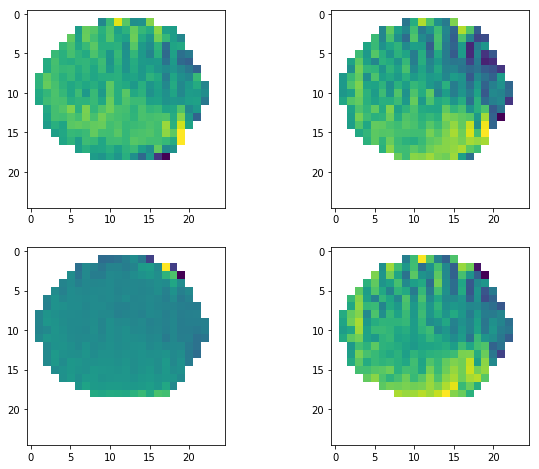

In [218]:
fig=plt.figure(figsize=(10, 8))
columns = 2
rows = 2
for i in range(1, columns*rows +1):
    img = raw_image_list[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [102]:
def preprocess_eog(eog):
    eog.filter(1, 15, method="iir", iir_params=None)
    return eog

In [103]:
def get_eog_channels(raw):
    picks = mne.pick_types(raw.info, meg=False, eeg=False, stim=False, eog=True, exclude='bads')
    raw.filter(1, 15, picks=picks, method="iir", iir_params=None)
    eog = raw.copy().pick_channels(['EOG062'])
    #raw = raw.pick_channels(['EOG061'])
    return eog

In [104]:
def get_eye_blink_time_points_array(eog):
    eog_data = eog.get_data()[0]
    threshold = np.max(eog_data)*2/3
    time_points = np.where(eog_data > threshold)
    return threshold, time_points[0]

In [105]:
def get_peak_time_point(time_points_array):
    start = time_points_array[0]
    end = time_points_array[0]
    peaks = []
    stored = time_points_array[0:5]
    for i in range(0, len(time_points_array)):
        if time_points_array[i] not in stored and (time_points_array[i]-1) not in stored:
            end = time_points_array[i-1]
            peak = start + int((end - start)/2)
            peaks.append(peak)
            start = time_points_array[i]
        if i >= 4:
            stored = time_points_array[i-4:i+1]
    return peaks

In [106]:
def random_markers(window_size, sampling_rate, marker):
    random_marker = []
    buffer = window_size*sampling_rate
    if len(marker) <= 0:
        return random_marker
    for i in range(len(marker)):
        if i == 0 and marker[0] > buffer:
            random_marker.append(random.randint(buffer,marker[0]))
        elif marker[i-1]+buffer < marker[i]-buffer:
            random_marker.append(random.randint(marker[i-1]+buffer,marker[i]-buffer))
    # HARD CODED length
    if marker[i]+buffer < 147000-buffer:
        random_marker.append(random.randint(marker[i]+buffer, 147000-buffer))
    return random_marker

In [107]:
def preprocessing(raw):
    picks = mne.pick_types(raw.info, meg='grad', eeg=False, stim=False, exclude='bads')
    #raw.filter(3, 40, picks=picks,l_trans_bandwidth='auto', filter_length='auto', phase='zero', fir_design='firwin')
    raw.filter(0.5, 25, picks=picks,l_trans_bandwidth='auto', filter_length='auto', phase='zero', fir_design='firwin')
    raw.notch_filter(60, picks=picks, fir_design='firwin')
    # channels = ['BG1-2511', 'BG2-2511', 'BG3-2511', 'BP1-2511', 'BP2-2511', 'BP3-2511', 'BQ1-2511', 'BQ2-2511', 'BQ3-2511', 'BR1-2511', 'BR2-2511', 'BR3-2511', 'G12-2511', 'G13-2511', 'G23-2511', 'P12-2511', 'P13-2511', 'Q12-2511', 'Q13-2511', 'Q21-2511', 'Q23-2511', 'R12-2511', 'R13-2511', 'R23-2511', 'SCLK01-177', 'G11-2511', 'G22-2511', 'P11-2511', 'P22-2511', 'Q11-2511', 'Q22-2511', 'R11-2511', 'R22-2511', 'Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2', 'EEG020', 'EEG021', 'EKG']
    # if b_drop_channels:
    # 	channels = ['BG1-2511', 'BG2-2511', 'BG3-2511', 'BP1-2511', 'BP2-2511', 'BP3-2511', 'BQ1-2511', 'BQ2-2511', 'BQ3-2511', 'BR1-2511', 'BR2-2511', 'BR3-2511', 'G12-2511', 'G13-2511', 'G23-2511', 'P12-2511', 'P13-2511', 'Q12-2511', 'Q13-2511', 'Q21-2511', 'Q23-2511', 'R12-2511', 'R13-2511', 'R23-2511', 'SCLK01-177', 'G11-2511', 'G22-2511', 'P11-2511', 'P22-2511', 'Q11-2511', 'Q22-2511', 'R11-2511', 'R22-2511', 'Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2', 'EEG020', 'EEG021', 'EKG']
    # 	raw = raw.drop_channels(channels)
    return raw

In [169]:
def load_data_events(dir_name):
    file_path = os.path.join(os.getcwd(), 'data/'+dir_name+'/meg/passive_raw.fif')
    raw =load_raw_data(file_path)
    data_preprocessed = preprocessing(raw)

    # add stimulus channel
    # positive = 1, negative = 2
    eog = get_eog_channels(raw)
    eye_blink_threshold, time_points_array = get_eye_blink_time_points_array(eog)
    eye_blink_peaks = get_peak_time_point(time_points_array)
    non_eye_blink_peaks = random_markers(0.2, 1000, eye_blink_peaks)
    # sample need to between raw.first_samp and raw.last_samp

    eye_blinks = []
    labels = []
    eye_blink_image_list = brain_map_interpolation(raw, 'grad', eye_blink_peaks)
    eye_blink_image_list_0 = np.nan_to_num(eye_blink_image_list, copy=True)
    for image in eye_blink_image_list_0:
        eye_blinks.append(image)
        labels.append(1)
    non_eye_blink_image_list = brain_map_interpolation(raw, 'grad', non_eye_blink_peaks)
    non_eye_blink_image_list_0 = np.nan_to_num(non_eye_blink_image_list, copy=True)
    for image in non_eye_blink_image_list_0:
        eye_blinks.append(image)
        labels.append(2)
# Deprecated code - using convert_to_image function
#     for i in eye_blink_peaks:
#         if i >= raw.first_samp and i <= raw.last_samp:
#             eye_blink_image = convert_to_image(raw, i, 'grad', channel_image)
#             eye_blinks.append(eye_blink_image)
#             labels.append(1)
#     for j in non_eye_blink_peaks:
#         if j >= raw.first_samp and j <= raw.last_samp:
#             non_eye_blink_image = convert_to_image(raw, j, 'grad', channel_image)
#             eye_blinks.append(non_eye_blink_image)
#             labels.append(2)
    return eye_blinks, labels

In [109]:
def load_all_epochs_data_from_list(dir_list):
    # do not convert to list
    eye_blinks_array = []
    labels_array = []

    for ds_file in dir_list:
        print('Start loading data...')
        print('From dataset: ' + ds_file)
        eye_blinks, labels = load_data_events(ds_file)
        eye_blinks_array = eye_blinks_array + eye_blinks
        labels_array = labels_array + labels
        
    return eye_blinks_array, labels_array

In [192]:
dir_list = os.listdir('data')
eye_blinks_array = []
labels_array = []

for ds_file in dir_list:
    print('Start loading data...')
    print('From dataset: ' + ds_file)
    eye_blinks, labels = load_data_events(ds_file)
    eye_blinks_array = eye_blinks_array + eye_blinks
    labels_array = labels_array + labels


Start loading data...
From dataset: sub-CC121397
Opening raw data file /Users/mlion0200/GitRepo/eye_blink_detection/data/sub-CC121397/meg/passive_raw.fif...
    Read a total of 8 projection items:
        mag_ssp_upright.fif : PCA-mags-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v5 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v3 (1 x 306)  idle
    Range : 16000 ... 163999 =     16.000 ...   163.999 secs
Ready.
Current compensation grade : 0
Reading 0 ... 147999  =      0.000 ...   147.999 secs...
Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Setting up band-pass filter from 0.5 - 25 Hz
l_trans_bandwidth chosen t

/anaconda3/envs/mne/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


Start loading data...
From dataset: sub-CC121158
Opening raw data file /Users/mlion0200/GitRepo/eye_blink_detection/data/sub-CC121158/meg/passive_raw.fif...
    Read a total of 8 projection items:
        mag_ssp_upright.fif : PCA-mags-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v5 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v3 (1 x 306)  idle
    Range : 15000 ... 159999 =     15.000 ...   159.999 secs
Ready.
Current compensation grade : 0
Reading 0 ... 144999  =      0.000 ...   144.999 secs...
Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Setting up band-pass filter from 0.5 - 25 Hz
l_trans_bandwidth chosen t

    Read a total of 8 projection items:
        mag_ssp_upright.fif : PCA-mags-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v5 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v3 (1 x 306)  idle
    Range : 16000 ... 161999 =     16.000 ...   161.999 secs
Ready.
Current compensation grade : 0
Reading 0 ... 145999  =      0.000 ...   145.999 secs...
Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Setting up band-pass filter from 0.5 - 25 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 6.2 Hz
Filter length of 6601 samples (6.601 sec) selected
Setting up band-stop filter from 59 - 61 Hz
Filter lengt

        mag_ssp_upright.fif : PCA-mags-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v5 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v3 (1 x 306)  idle
    Range : 31000 ... 177999 =     31.000 ...   177.999 secs
Ready.
Current compensation grade : 0
Reading 0 ... 146999  =      0.000 ...   146.999 secs...
Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Setting up band-pass filter from 0.5 - 25 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 6.2 Hz
Filter length of 6601 samples (6.601 sec) selected
Setting up band-stop filter from 59 - 61 Hz
Filter length of 6601 samples (6.601 sec) selected
Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Setting 

        mag_ssp_upright.fif : PCA-mags-v5 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v3 (1 x 306)  idle
    Range : 17000 ... 162999 =     17.000 ...   162.999 secs
Ready.
Current compensation grade : 0
Reading 0 ... 145999  =      0.000 ...   145.999 secs...
Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Setting up band-pass filter from 0.5 - 25 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 6.2 Hz
Filter length of 6601 samples (6.601 sec) selected
Setting up band-stop filter from 59 - 61 Hz
Filter length of 6601 samples (6.601 sec) selected
Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Setting up band-pass filter from 1 - 15 Hz
Start loading data...
From dataset: sub-CC220506
Opening raw data file /Users/mli

        grad_ssp_upright.fif : PCA-grad-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v3 (1 x 306)  idle
    Range : 15000 ... 162999 =     15.000 ...   162.999 secs
Ready.
Current compensation grade : 0
Reading 0 ... 147999  =      0.000 ...   147.999 secs...
Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Setting up band-pass filter from 0.5 - 25 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 6.2 Hz
Filter length of 6601 samples (6.601 sec) selected
Setting up band-stop filter from 59 - 61 Hz
Filter length of 6601 samples (6.601 sec) selected
Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Setting up band-pass filter from 1 - 15 Hz
Start loading data...
From dataset: sub-CC210088
Opening raw data file /Users/mlion0200/GitRepo/eye_blink_detection/data/sub-CC210088/meg/passive_raw.fif...
    Read a total of 8 projection items:
 

    Range : 16000 ... 164999 =     16.000 ...   164.999 secs
Ready.
Current compensation grade : 0
Reading 0 ... 148999  =      0.000 ...   148.999 secs...
Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Setting up band-pass filter from 0.5 - 25 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 6.2 Hz
Filter length of 6601 samples (6.601 sec) selected
Setting up band-stop filter from 59 - 61 Hz
Filter length of 6601 samples (6.601 sec) selected
Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Setting up band-pass filter from 1 - 15 Hz
Start loading data...
From dataset: sub-CC120640
Opening raw data file /Users/mlion0200/GitRepo/eye_blink_detection/data/sub-CC120640/meg/passive_raw.fif...
    Read a total of 8 projection items:
        mag_ssp_upright.fif : PCA-mags-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v2 (1 x 306)  idle
   

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Setting up band-pass filter from 0.5 - 25 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 6.2 Hz
Filter length of 6601 samples (6.601 sec) selected
Setting up band-stop filter from 59 - 61 Hz
Filter length of 6601 samples (6.601 sec) selected
Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Setting up band-pass filter from 1 - 15 Hz
Start loading data...
From dataset: sub-CC220098
Opening raw data file /Users/mlion0200/GitRepo/eye_blink_detection/data/sub-CC220098/meg/passive_raw.fif...
    Read a total of 8 projection items:
        mag_ssp_upright.fif : PCA-mags-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v5 (

Setting up band-pass filter from 0.5 - 25 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 6.2 Hz
Filter length of 6601 samples (6.601 sec) selected
filter_length (6601) is longer than the signal (2000), distortion is likely. Reduce filter length or filter a longer signal.
Setting up band-pass filter from 0.5 - 25 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 6.2 Hz
Filter length of 6601 samples (6.601 sec) selected


<ipython-input-107-3426c35aa1c7>:4: RuntimeWarning: filter_length (6601) is longer than the signal (2000), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5, 25, picks=picks,l_trans_bandwidth='auto', filter_length='auto', phase='zero', fir_design='firwin')


Setting up band-stop filter from 59 - 61 Hz
Filter length of 6601 samples (6.601 sec) selected
Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Setting up band-pass filter from 1 - 15 Hz
Setting up band-pass filter from 1 - 15 Hz
Start loading data...
From dataset: sub-CC220518
Opening raw data file /Users/mlion0200/GitRepo/eye_blink_detection/data/sub-CC220518/meg/passive_raw.fif...
    Read a total of 8 projection items:
        mag_ssp_upright.fif : PCA-mags-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v5 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v3 (1 x 306)  idle
    Range : 17000 ... 171999 =     17.000 ... 

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Setting up band-pass filter from 1 - 15 Hz
Start loading data...
From dataset: sub-CC210172
Opening raw data file /Users/mlion0200/GitRepo/eye_blink_detection/data/sub-CC210172/meg/passive_raw.fif...
    Read a total of 8 projection items:
        mag_ssp_upright.fif : PCA-mags-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v5 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v3 (1 x 306)  idle
    Range : 16000 ... 165999 =     16.000 ...   165.999 secs
Ready.
Current compensation grade : 0
Reading 0 ... 149999  =      0.000 ...   149.999 secs...
Filtering a subset of channe

Setting up band-pass filter from 1 - 15 Hz
Start loading data...
From dataset: sub-CC220535
Opening raw data file /Users/mlion0200/GitRepo/eye_blink_detection/data/sub-CC220535/meg/passive_raw.fif...
    Read a total of 8 projection items:
        mag_ssp_upright.fif : PCA-mags-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v5 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v3 (1 x 306)  idle
    Range : 18000 ... 166999 =     18.000 ...   166.999 secs
Ready.
Current compensation grade : 0
Reading 0 ... 148999  =      0.000 ...   148.999 secs...
Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Setting up band-pass filter 

    Read a total of 8 projection items:
        mag_ssp_upright.fif : PCA-mags-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v5 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v3 (1 x 306)  idle
    Range : 64000 ... 214999 =     64.000 ...   214.999 secs
Ready.
Current compensation grade : 0
Reading 0 ... 150999  =      0.000 ...   150.999 secs...
Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Setting up band-pass filter from 0.5 - 25 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 6.2 Hz
Filter length of 6601 samples (6.601 sec) selected
Setting up band-stop filter from 59 - 61 Hz
Filter lengt

        mag_ssp_upright.fif : PCA-mags-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v5 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v3 (1 x 306)  idle
    Range : 20000 ... 165999 =     20.000 ...   165.999 secs
Ready.
Current compensation grade : 0
Reading 0 ... 145999  =      0.000 ...   145.999 secs...
Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Setting up band-pass filter from 0.5 - 25 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 6.2 Hz
Filter length of 6601 samples (6.601 sec) selected
Setting up band-stop filter from 59 - 61 Hz
Filter length of 6601 samples (6.601 sec) selected
Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Setting 

In [113]:
from sklearn.preprocessing import StandardScaler
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [114]:
scaler = StandardScaler()

In [91]:
eye_blinks_norm = []
for i in range(0,len(eye_blinks)):
    eye_blinks_norm.append(scaler.fit_transform(eye_blinks[i]))

In [193]:
eye_blinks_norm = []
for i in range(0,len(eye_blinks_array)):
    eye_blinks_norm.append(scaler.fit_transform(eye_blinks_array[i]))

In [194]:
(train_data, test_data, train_labels, test_labels) = train_test_split(eye_blinks_norm, labels_array, test_size = 0.2)

In [195]:
train_data_array = np.asarray(train_data)
test_data_array = np.asarray(test_data)

In [196]:
train_data_array_image = train_data_array - train_data_array.min()
train_data_array_image*= (255.0/train_data_array_image.max())

In [197]:
fig=plt.figure()

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Index: 6')

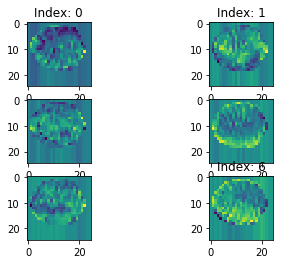

In [198]:
plt.subplot(321)
plt.imshow(train_data_array_image[0])
plt.title('Index: 0')
plt.subplot(322)
plt.imshow(train_data_array_image[1])
plt.title('Index: 1')
plt.subplot(323)
plt.imshow(train_data_array_image[2])
plt.subplot(324)
plt.imshow(train_data_array_image[3])
plt.subplot(325)
plt.imshow(train_data_array_image[4])
plt.subplot(326)
plt.imshow(train_data_array_image[6])
plt.title('Index: 6')

In [199]:
train_data_array.shape

(2994, 25, 25)

In [200]:
test_data_array.shape

(749, 25, 25)

In [201]:
train_data_array_reshape = train_data_array.reshape(2994, 25, 25, 1)

In [202]:
test_data_array_reshape = test_data_array.reshape(749, 25, 25, 1)

In [203]:
from keras.utils import to_categorical
y_binary = to_categorical(train_labels)

In [204]:
y_test_binary = to_categorical(test_labels)

In [205]:
test_labels

[2,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 2,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 1,


In [206]:
y_test_binary

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [207]:
model = Sequential()

# Add the first convolution layer
model.add(Convolution2D(
    filters = 20,
    kernel_size = (3, 3),
    padding = "same",
    input_shape = (25, 25, 1)))

# Add a ReLU activation function
model.add(Activation(
    activation = "relu"))

# Add a pooling layer
model.add(MaxPooling2D(
    pool_size = (2, 2),
    strides =  (2, 2)))

# Add the second convolution layer
model.add(Convolution2D(
    filters = 50,
    kernel_size = (5, 5),
    padding = "same"))

# Add a ReLU activation function
model.add(Activation(
    activation = "relu"))

# Add a second pooling layer
model.add(MaxPooling2D(
    pool_size = (2, 2),
    strides = (2, 2)))

# Flatten the network
model.add(Flatten())

# Add a fully-connected hidden layer
model.add(Dense(200))

# Add a ReLU activation function
model.add(Activation(
    activation = "relu"))

# Add a fully-connected output layer
model.add(Dense(3))

# Add a softmax activation function
model.add(Activation("sigmoid"))

# Compile the network
model.compile(
    loss = "categorical_crossentropy", 
    optimizer = SGD(lr = 0.01),
    metrics = ["accuracy"])

In [208]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 25, 25, 20)        200       
_________________________________________________________________
activation_9 (Activation)    (None, 25, 25, 20)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 20)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 50)        25050     
_________________________________________________________________
activation_10 (Activation)   (None, 12, 12, 50)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 50)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1800)              0         
__________

In [209]:
# Train the model 
model.fit(
    train_data_array_reshape, 
    y_binary, 
    batch_size = 3, 
    epochs = 5)

Epoch 1/5
2994/2994 [==============================] - 4s 1ms/step - loss: 0.1547 - acc: 0.9519
Epoch 2/5
2994/2994 [==============================] - 4s 1ms/step - loss: 0.1028 - acc: 0.9709
Epoch 3/5
2994/2994 [==============================] - 4s 1ms/step - loss: 0.0923 - acc: 0.9753
Epoch 4/5
2994/2994 [==============================] - 4s 1ms/step - loss: 0.0828 - acc: 0.9780
Epoch 5/5
2994/2994 [==============================] - 4s 1ms/step - loss: 0.0773 - acc: 0.9790


In [210]:
# Evaluate the model
(loss, accuracy) = model.evaluate(
    test_data_array_reshape, 
    y_test_binary,
    batch_size = 3, 
    verbose = 1)

# Print the model's accuracy
print(accuracy)

749/749 [==============================] - 0s 428us/step
0.9719626184935882


In [211]:
predicted_array = model.predict(test_data_array_reshape)

In [212]:
np.argmax(predicted_array, axis=1)

array([2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2,
       2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1,
       2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2,
       2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1,
       1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2,
       1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 2,
       1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2,
       1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1,
       2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1,
       2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2,
       2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2,
       1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2,

In [213]:
np.argmax(y_test_binary, axis=1)

array([2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2,
       2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1,
       2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2,
       2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1,
       1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1,
       1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2,
       1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2,
       1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2,
       1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1,
       2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1,
       2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2,
       2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2,
       1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2,

In [214]:
model = Sequential()

# Add the first convolution layer
model.add(Convolution2D(
    filters = 20,
    kernel_size = (3, 3),
    padding = "same",
    input_shape = (25, 25, 1)))

# Add a pooling layer
model.add(MaxPooling2D(
    pool_size = (2, 2)))

# Add the second convolution layer
model.add(Convolution2D(
    filters = 50,
    kernel_size = (5, 5),
    padding = "same"))

# Add a pooling layer
model.add(MaxPooling2D(
    pool_size = (2, 2)))

# Add the second convolution layer
model.add(Convolution2D(
    filters = 50,
    kernel_size = (4, 4),
    padding = "same"))


# Add the second convolution layer
model.add(Convolution2D(
    filters = 50,
    kernel_size = (4, 4),
    padding = "same"))

# Add a ReLU activation function
model.add(Activation(
    activation = "relu"))

# Flatten the network
model.add(Flatten())

# Add a fully-connected hidden layer
model.add(Dense(200))

# Add a fully-connected hidden layer
model.add(Dense(50))

# Add a ReLU activation function
model.add(Activation(
    activation = "relu"))

# Add a fully-connected output layer
model.add(Dense(3))

# Add a softmax activation function
model.add(Activation("sigmoid"))

# Compile the network
model.compile(
    loss = "categorical_crossentropy", 
    optimizer = SGD(lr = 0.01),
    metrics = ["accuracy"])

In [215]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 25, 25, 20)        200       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 20)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 50)        25050     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 6, 6, 50)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 6, 6, 50)          40050     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 6, 6, 50)          40050     
_________________________________________________________________
activation_13 (Activation)   (None, 6, 6, 50)          0         
__________

In [216]:
# Train the model 
model.fit(
    train_data_array_reshape, 
    y_binary, 
    batch_size = 3, 
    epochs = 5)

Epoch 1/5
2994/2994 [==============================] - 7s 2ms/step - loss: 0.1563 - acc: 0.9539
Epoch 2/5
2994/2994 [==============================] - 6s 2ms/step - loss: 0.1052 - acc: 0.9699
Epoch 3/5
2994/2994 [==============================] - 6s 2ms/step - loss: 0.0909 - acc: 0.9733
Epoch 4/5
2994/2994 [==============================] - 7s 2ms/step - loss: 0.0844 - acc: 0.9763
Epoch 5/5
2994/2994 [==============================] - 6s 2ms/step - loss: 0.0757 - acc: 0.9780


In [217]:
# Evaluate the model
(loss, accuracy) = model.evaluate(
    test_data_array_reshape, 
    y_test_binary,
    batch_size = 3, 
    verbose = 1)

# Print the model's accuracy
print(accuracy)

749/749 [==============================] - 0s 595us/step
0.9719626184935882


In [137]:
predicted_array = model.predict(test_data_array_reshape)

In [138]:
np.argmax(predicted_array, axis=1)

array([1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1,
       1, 2, 2, 1, 2, 2, 2, 2, 2])

In [139]:
np.argmax(y_test_binary, axis=1)

array([1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1,
       1, 2, 2, 1, 2, 2, 2, 2, 2])

In [192]:
def load_all_data_from_list(dir_list):
    epochs_array = []
    labels_array = []

    for ds_file in dir_list:
        print('Start loading data...')
        print('From dataset: ' + ds_file)
        eye_blinks, labels = load_data_events(ds_file)
        eye_blinks_array += eye_blinks.tolist()
        labels_array += labels.tolist()

    return eye_blinks_array, labels_array

In [63]:
dir_list = os.listdir('data')
eye_blinks_array, labels_array = load_all_data_from_list(dir_list)

Start loading data...
From dataset: sub-CC221980
Opening raw data file /Users/mlion0200/GitRepo/eye_blink_detection/data/sub-CC221980/meg/passive_raw.fif...
    Read a total of 8 projection items:
        mag_ssp_upright.fif : PCA-mags-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v5 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v3 (1 x 306)  idle
    Range : 18000 ... 164999 =     18.000 ...   164.999 secs
Ready.
Current compensation grade : 0
Reading 0 ... 146999  =      0.000 ...   146.999 secs...
Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Setting up band-pass filter from 0.5 - 25 Hz
l_trans_bandwidth chosen t

IndexError: index 20126 is out of bounds for axis 0 with size 339

In [19]:
def convert_to_image(raw, time_point, ch_type, channel_image):
    data_image = [[0 for i in range(15)] for j in range(15)]
    for i in range(0, len(channel_image)):
        for j in range(0, len(channel_image[i])):
            if channel_image[i][j] == 0:
                continue
            channel_name = [channel_image[i][j][0]]
            picks = mne.pick_channels(raw.info['ch_names'], include=channel_name)
            channel_raw_data = raw.copy().get_data(picks=picks).T[time_point]
            len(channel_raw_data)
            del channel_name
            data_image[i][j] = channel_raw_data
    
    return data_image

In [29]:
picks = mne.pick_channels(raw.info['ch_names'], include=['MEG1543'])
channel_raw_data = raw.copy().get_data(picks=picks)

In [30]:
channel_raw_data

array([[-3.43418126e-11, -2.58493427e-11, -2.60353092e-11, ...,
        -7.41944324e-10,  5.89513787e-10,  3.24263577e-10]])

In [25]:
## Not sure what this does
# layout = mne.channels.make_grid_layout(raw.info, picks=None)

In [26]:
data_image = convert_to_image(raw, 'grad', channel_image)

len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1
len: 1

In [174]:
dict(sorted(sorted_pos[0:9], key=lambda e:e[1][1]))

{'MEG1533': [0.07129470931078981, 0.266302130525918],
 'MEG1532': [0.07129470931078981, 0.304069053339759],
 'MEG1543': [0.03152389623260022, 0.4040458100336345],
 'MEG1542': [0.03152389623260022, 0.4418127328474753],
 'MEG1512': [0.07325235775484526, 0.48105909932870283],
 'MEG0143': [0.028252427184466015, 0.5599149537006284],
 'MEG0142': [0.028252427184466015, 0.5976818765144694],
 'MEG0113': [0.0629897705374108, 0.7163991694725684],
 'MEG0112': [0.0629897705374108, 0.7541660922864094]}

In [21]:
len(data_image[0])

15

In [16]:
channel_image

[[0,
  0,
  0,
  ('MEG1533', [0.07129470931078981, 0.266302130525918]),
  ('MEG1532', [0.07129470931078981, 0.304069053339759]),
  ('MEG1543', [0.03152389623260022, 0.4040458100336345]),
  ('MEG1542', [0.03152389623260022, 0.4418127328474753]),
  ('MEG1512', [0.07325235775484526, 0.48105909932870283]),
  ('MEG0143', [0.028252427184466015, 0.5599149537006284]),
  ('MEG0142', [0.028252427184466015, 0.5976818765144694]),
  ('MEG0113', [0.0629897705374108, 0.7163991694725684]),
  ('MEG0112', [0.0629897705374108, 0.7541660922864094]),
  0,
  0,
  0],
 [0,
  0,
  ('MEG1722', [0.14164551309211484, 0.2426420673425788]),
  ('MEG1723', [0.14164551309211484, 0.28040899015641974]),
  ('MEG1522', [0.09272471123581737, 0.3556369765830014]),
  ('MEG1523', [0.09272471123581737, 0.3934038993968423]),
  ('MEG0243', [0.13150614423705279, 0.4928465033945925]),
  ('MEG1513', [0.07325235775484526, 0.5188260221425438]),
  ('MEG0242', [0.13150614423705279, 0.5306134262084333]),
  ('MEG0132', [0.08915398464469

In [2]:
from mne import read_evokeds

In [3]:
evoked = read_evokeds('data/sub-CC310385/meg/passive_raw.fif')

This filename (data/sub-CC310385/meg/passive_raw.fif) does not conform to MNE naming conventions. All evoked files should end with -ave.fif, -ave.fif.gz, _ave.fif or _ave.fif.gz
Reading data/sub-CC310385/meg/passive_raw.fif ...


<ipython-input-3-b1f773540783>:1: RuntimeWarning: This filename (data/sub-CC310385/meg/passive_raw.fif) does not conform to MNE naming conventions. All evoked files should end with -ave.fif, -ave.fif.gz, _ave.fif or _ave.fif.gz
  evoked = read_evokeds('data/sub-CC310385/meg/passive_raw.fif')


[]

In [7]:
evoked.plot_topomap(5, ch_type='grad', time_unit='s')

AttributeError: 'list' object has no attribute 'plot_topomap'